# pvsystem tutorial

This tutorial explores the ``pvlib.pvsystem`` module. The module has functions for importing PV module and inverter data and functions for modeling module and inverter performance.

1. [systemdef](#systemdef)
2. [Angle of Incidence Modifiers](#Angle-of-Incidence-Modifiers)
2. [Sandia Cell Temp correction](#Sandia-Cell-Temp-correction)
2. [Sandia Inverter Model](#snlinverter)
2. [Sandia Array Performance Model](#SAPM)
    1. [SAPM IV curves](#SAPM-IV-curves)
2. [DeSoto Model](#desoto)
2. [Single Diode Model](#Single-diode-model)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except ImportError:
    pass

# built in python modules
import datetime
import logging
import os
import inspect

try:
    from importlib import reload
except:
    pass

# python add-ons
import numpy as np
import pandas as pd

In [2]:
import pvlib
from pvlib import pvsystem

### systemdef

``pvlib`` can import TMY2 and TMY3 data. Here, we import the example files.

In [3]:
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

tmy3_data, tmy3_metadata = pvlib.tmy.readtmy3(os.path.join(pvlib_abspath, 'data', '703165TY.csv'))
tmy2_data, tmy2_metadata = pvlib.tmy.readtmy2(os.path.join(pvlib_abspath, 'data', '12839.tm2'))

In [4]:
pvlib.pvsystem.systemdef(tmy3_metadata, 0, 0, .1, 5, 5)

{'albedo': 0.1,
 'altitude': 7.0,
 'latitude': 55.317,
 'longitude': -160.517,
 'name': '"SAND POINT"',
 'parallel_modules': 5,
 'series_modules': 5,
 'surface_azimuth': 0,
 'surface_tilt': 0,
 'tz': -9.0}

In [5]:
pvlib.pvsystem.systemdef(tmy2_metadata, 0, 0, .1, 5, 5)

{'albedo': 0.1,
 'altitude': 2.0,
 'latitude': 25.8,
 'longitude': -80.26666666666667,
 'name': 'MIAMI',
 'parallel_modules': 5,
 'series_modules': 5,
 'surface_azimuth': 0,
 'surface_tilt': 0,
 'tz': -5}

### Angle of Incidence Modifiers

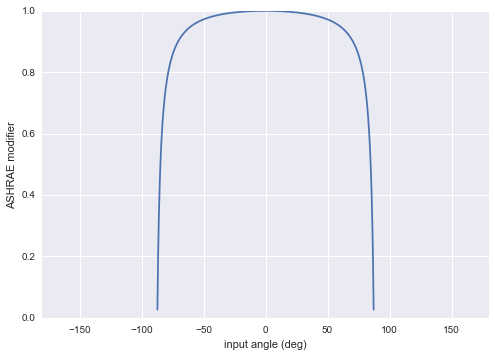

In [6]:
angles = np.linspace(-180,180,3601)
ashraeiam = pd.Series(pvsystem.ashraeiam(.05, angles), index=angles)

ashraeiam.plot();
plt.ylabel('ASHRAE modifier');
plt.xlabel('input angle (deg)');

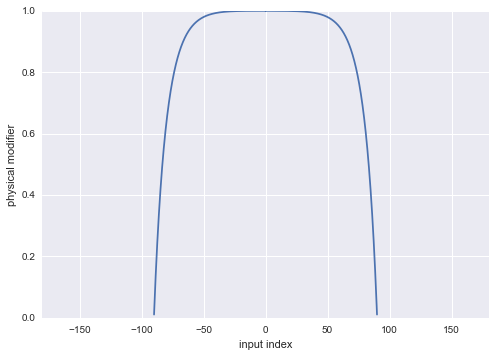

In [7]:
angles = np.linspace(-180,180,3601)
physicaliam = pd.Series(pvsystem.physicaliam(4, 0.002, 1.526, angles), index=angles)

physicaliam.plot();
plt.ylabel('physical modifier');
plt.xlabel('input index');

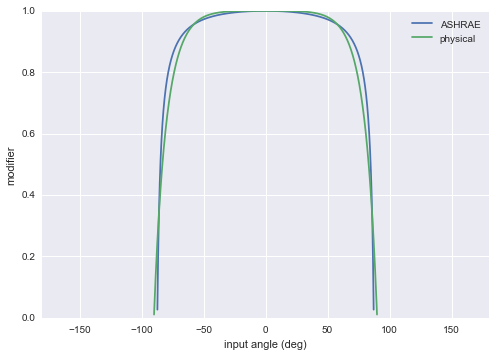

In [8]:
plt.figure();
ashraeiam.plot(label='ASHRAE');
physicaliam.plot(label='physical');
plt.ylabel('modifier');
plt.xlabel('input angle (deg)');
plt.legend();

### Sandia Cell Temp correction

PV system efficiency can vary by up to 0.5% per degree C, so it's important to accurately model cell and module temperature. The ``sapm_celltemp`` function uses plane of array irradiance, ambient temperature, wind speed, and module and racking type to calculate cell and module temperatures. From King et. al. (2004):

$$T_m = E e^{a+b*WS} + T_a$$

$$T_c = T_m + \frac{E}{E_0} \Delta T$$

The $a$, $b$, and $\Delta T$ parameters depend on the module and racking type. The default parameter set is ``open_rack_cell_glassback``.

``sapm_celltemp`` works with either scalar or vector inputs, but always returns a pandas DataFrame.

In [9]:
# scalar inputs
pvsystem.sapm_celltemp(900, 5, 20) # irrad, wind, temp

,temp_cell,temp_module
0,43.509191,40.809191


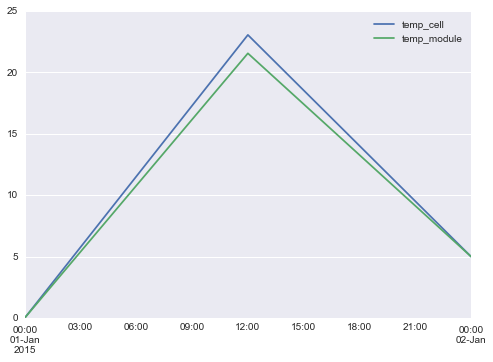

In [10]:
# vector inputs
times = pd.DatetimeIndex(start='2015-01-01', end='2015-01-02', freq='12H')
temps = pd.Series([0, 10, 5], index=times)
irrads = pd.Series([0, 500, 0], index=times)
winds = pd.Series([10, 5, 0], index=times)

pvtemps = pvsystem.sapm_celltemp(irrads, winds, temps)
pvtemps.plot();

Cell and module temperature as a function of wind speed.

<type 'numpy.ndarray'>


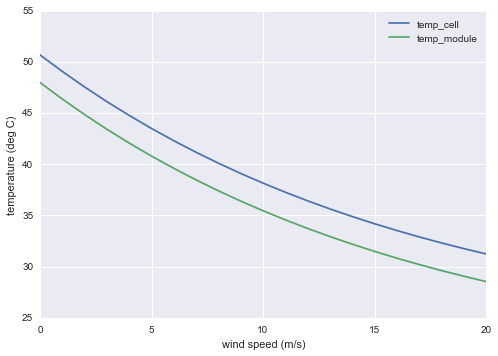

In [11]:
wind = np.linspace(0,20,21)
print(type(wind))



temps = pd.DataFrame(pvsystem.sapm_celltemp(900, wind, 20), index=wind)


temps.plot();
plt.legend();
plt.xlabel('wind speed (m/s)');
plt.ylabel('temperature (deg C)');

Cell and module temperature as a function of ambient temperature.

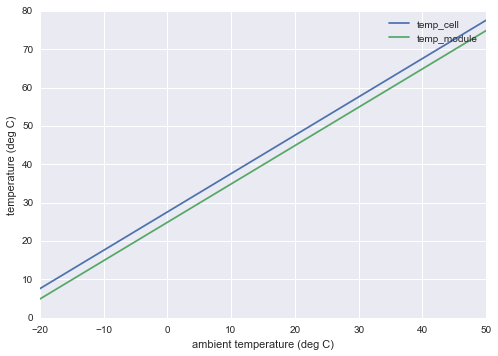

In [12]:
atemp = np.linspace(-20,50,71)
temps = pvsystem.sapm_celltemp(900, 2, atemp).set_index(atemp)

temps.plot();
plt.legend();
plt.xlabel('ambient temperature (deg C)');
plt.ylabel('temperature (deg C)');

Cell and module temperature as a function of incident irradiance.

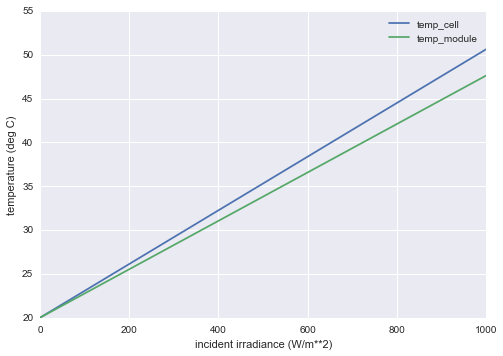

In [13]:
irrad = np.linspace(0,1000,101)
temps = pvsystem.sapm_celltemp(irrad, 2, 20).set_index(irrad)

temps.plot();
plt.legend();
plt.xlabel('incident irradiance (W/m**2)');
plt.ylabel('temperature (deg C)');

Cell and module temperature for different module and racking types.

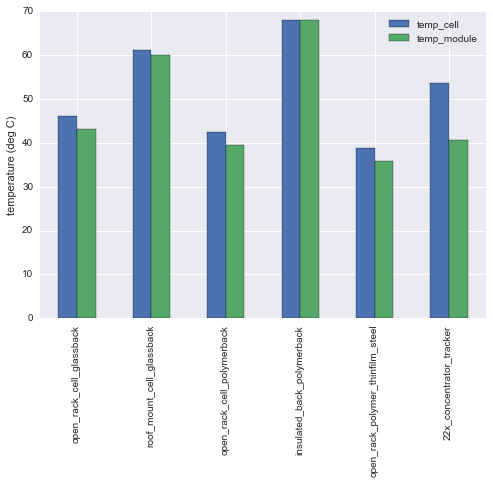

In [14]:
models = ['open_rack_cell_glassback',
          'roof_mount_cell_glassback',
          'open_rack_cell_polymerback',
          'insulated_back_polymerback',
          'open_rack_polymer_thinfilm_steel',
          '22x_concentrator_tracker']

temps = pd.DataFrame(index=['temp_cell','temp_module'])

for model in models:
    temps[model] = pd.Series(pvsystem.sapm_celltemp(1000, 5, 20, model=model).ix[0])

temps.T.plot(kind='bar'); # try removing the transpose operation and replotting
plt.legend();
plt.ylabel('temperature (deg C)');

### snlinverter

In [15]:
inverters = pvsystem.retrieve_sam('sandiainverter', samfile='c:/sandiainverter.csv', updatelocalFile=False)
inverters

,ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_,ABB__MICRO_0_25_I_OUTD_US_240_240V__CEC_2014_,ABB__MICRO_0_3HV_I_OUTD_US_208_208V__CEC_2014_,ABB__MICRO_0_3HV_I_OUTD_US_240_240V__CEC_2014_,ABB__MICRO_0_3_I_OUTD_US_208_208V__CEC_2014_,ABB__MICRO_0_3_I_OUTD_US_240_240V__CEC_2014_,Ablerex_Electronics_Co___Ltd___ES_2200_US_240__240_Vac__240V__CEC_2011_,Ablerex_Electronics_Co___Ltd___ES_3300_US_240__240_Vac__240V__CEC_2011_,Ablerex_Electronics_Co___Ltd___ES_4200_US_240__240_Vac__240V__CEC_2011_,Ablerex_Electronics_Co___Ltd___ES_5000_US_240__240_Vac__240V__CEC_2011_,...,Yes!_Solar_Inc___ES5000__240V__240V__CEC_2009_,Yes!_Solar_Inc___ES5300__208V__208V__CEC_2009_,Yes!_Solar_Inc___ES5300__240V__240V__CEC_2009_,Zhejiang_Yuhui_Solar_Energy_Source__Replus_250A_240V__CEC_2012_,Zhejiang_Yuhui_Solar_Energy_Source__Replus_250B_208V__CEC_2012_,Zigor__Sunzet_2_TL_US_240V__CEC_2011_,Zigor__Sunzet_3_TL_US_240V__CEC_2011_,Zigor__Sunzet_4_TL_US_240V__CEC_2011_,Zigor__Sunzet_5_TL_US_240V__CEC_2011_,Zigor__SUNZET4_USA_240V__CEC_2011_
Vac,208.000000,240.000000,208.000000,240.000000,208.000000,240.000000,240.000000,240.000000,240.000000,240.000000,...,240.000000,208.000000,240.000000,2.400000e+02,208.000000,240.000000,240.000000,240.000000,240.000000,240.000000
Paco,250.000000,250.000000,300.000000,300.000000,300.000000,300.000000,2110.000000,3180.000000,4160.000000,5240.000000,...,4900.000000,4600.000000,5300.000000,2.251900e+02,213.830000,2110.000000,3180.000000,4160.000000,5240.000000,4030.000000
Pdco,259.522000,259.553000,312.523000,312.022000,311.715000,311.505000,2191.830000,3313.680000,4342.410000,5495.830000,...,5135.580000,4829.420000,5571.180000,2.348420e+02,225.563000,2191.830000,3313.680000,4342.410000,5495.830000,4267.480000
Vdco,40.242600,39.982200,45.259400,45.495000,40.227100,40.136100,399.207000,389.513000,388.562000,386.083000,...,275.000000,275.000000,274.900000,2.846840e+01,28.632600,399.207000,389.513000,388.562000,386.083000,302.852000
Pso,1.771610,1.931190,1.882620,1.928590,1.971050,1.991340,30.843700,31.265000,31.601700,32.450800,...,29.358900,26.071500,28.519000,1.646710e+00,1.845030,30.843700,31.265000,31.601700,32.450800,37.372800
C0,-0.000025,-0.000027,-0.000049,-0.000035,-0.000036,-0.000031,-0.000004,-0.000006,-0.000004,-0.000005,...,-0.000006,-0.000006,-0.000006,-3.859730e-07,-0.000121,-0.000004,-0.000006,-0.000004,-0.000005,-0.000009
C1,-0.000090,-0.000158,-0.000241,-0.000228,-0.000256,-0.000289,-0.000077,-0.000095,-0.000079,-0.000097,...,0.000020,0.000024,0.000019,-3.578480e-04,-0.000533,-0.000077,-0.000095,-0.000079,-0.000097,-0.000029
C2,0.000669,0.001476,0.000975,-0.000224,-0.000833,-0.002113,0.000502,0.000261,0.000213,-0.000251,...,0.001868,0.002618,0.001630,-1.345040e-02,0.025867,0.000502,0.000261,0.000213,-0.000251,0.002147
C3,-0.018881,-0.034601,-0.027563,-0.039636,-0.039102,-0.049515,-0.003258,-0.001956,-0.001867,-0.002337,...,-0.000276,0.000468,-0.000371,-3.350680e+01,-0.066826,-0.003258,-0.001956,-0.001867,-0.002337,-0.001897
Pnt,0.020000,0.050000,0.060000,0.060000,0.020000,0.050000,0.250000,0.250000,0.200000,0.200000,...,0.500000,0.500000,0.500000,1.700000e-01,0.170000,0.250000,0.250000,0.200000,0.200000,0.190000


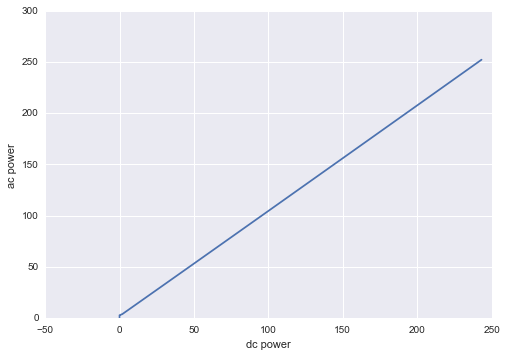

In [16]:
vdcs = pd.Series(np.linspace(0,50,51))
idcs = pd.Series(np.linspace(0,11,110))
pdcs = idcs * vdcs

pacs = pvsystem.snlinverter(inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_'], vdcs, pdcs)
#pacs.plot();
plt.plot(pacs, pdcs);
plt.ylabel('ac power');
plt.xlabel('dc power');

Need to put more effort into describing this function.

### SAPM

The CEC module database.

In [17]:
cec_modules = pvsystem.retrieve_sam('cecmod', samfile='c:/cecmod.csv', updatelocalFile=False)
cec_modules

,BEoptCA_Default_Module,Example_Module,1Soltech_1STH_215_P,1Soltech_1STH_220_P,1Soltech_1STH_225_P,1Soltech_1STH_230_P,1Soltech_1STH_235_WH,1Soltech_1STH_240_WH,1Soltech_1STH_245_WH,1Soltech_1STH_FRL_4H_245_M60_BLK,...,Znshine_PV_Tech_ZXM6_72_315_M,Znshine_PV_Tech_ZXP6_72_315_P,Znshine_PV_Tech_ZXM6_72_320_M,Znshine_PV_Tech_ZXM6_72_325_M,Znshine_PV_Tech_ZXM6_72_330_M,Zytech_Engineering_Technology_ZT170S,Zytech_Engineering_Technology_ZT175S,Zytech_Engineering_Technology_ZT180S,Zytech_Engineering_Technology_ZT185S,Zytech_Engineering_Technology_ZT190S
T_noct,65,65,47.4,47.4,47.4,47.4,49.9,49.9,49.9,48.3,...,47,47,47,47,47,46,46,46.8,46.8,46.8
A_c,0.67,0.67,1.567,1.567,1.567,1.567,1.635,1.635,1.635,1.668,...,1.941,1.941,1.941,1.941,1.941,1.277,1.277,1.277,1.277,1.277
N_s,18,18,60,60,60,60,60,60,60,60,...,72,72,72,72,72,72,72,72,72,72
I_sc_ref,7.5,7.5,7.84,7.97,8.09,8.18,8.54,8.58,8.62,8.81,...,8.91,8.95,8.99,9.09,9.19,4.98,5.36,5.21,5.3,5.5
V_oc_ref,10.4,10.4,36.3,36.6,36.9,37.1,37,37.1,37.2,38.3,...,46.45,45.22,46.54,46.63,46.72,44.21,44.57,44.71,45,44.86
I_mp_ref,6.6,6.6,7.35,7.47,7.58,7.65,8.02,8.07,8.1,8.06,...,8.32,8.45,8.43,8.54,8.65,4.63,4.7,4.79,4.87,5.04
V_mp_ref,8.4,8.4,29,29.3,29.6,29.9,29.3,29.7,30.2,30.2,...,37.86,37.28,37.96,38.06,38.15,36.72,37.22,37.58,38.09,37.73
Alpha_sc,0.003,0.003,0.007997,0.008129,0.008252,0.008344,0.00743,0.007465,0.007499,0.006167,...,0.00499,0.00546,0.005034,0.00509,0.005146,0.003735,0.00402,0.005314,0.005406,0.00561
Beta_oc,-0.04,-0.04,-0.13104,-0.13213,-0.13321,-0.13393,-0.13653,-0.1369,-0.13727,-0.13635,...,-0.14864,-0.16686,-0.14893,-0.14922,-0.1495,-0.16579,-0.16714,-0.16274,-0.1638,-0.16329
A_ref,0.473,0.473,1.6413,1.6572,1.6732,1.6888,1.6292,1.6425,1.6617,1.6351,...,1.9594,1.9767,1.9592,1.9616,1.9638,2.0618,2.1732,2.0685,2.0917,2.0806


In [18]:
cecmodule = cec_modules.Example_Module 
cecmodule

T_noct              65
A_c               0.67
N_s                 18
I_sc_ref           7.5
V_oc_ref          10.4
I_mp_ref           6.6
V_mp_ref           8.4
Alpha_sc         0.003
Beta_oc          -0.04
A_ref            0.473
I_l_ref          7.545
I_o_ref      1.943e-09
R_s              0.094
R_sh_ref         15.72
Adjust            10.6
Gamma_r           -0.5
Source      Multi-c-Si
Name: Example_Module, dtype: object

The Sandia module database.

In [19]:
sandia_modules = pvlib.pvsystem.retrieve_sam(name='SandiaMod', samfile='c:/SandiaMod.csv', updatelocalFile=False)
sandia_modules

,Advent_Solar_AS160___2006_,Advent_Solar_Ventura_210___2008_,Advent_Solar_Ventura_215___2009_,Aleo_S03_160__2007__E__,Aleo_S03_165__2007__E__,Aleo_S16_165__2007__E__,Aleo_S16_170__2007__E__,Aleo_S16_175__2007__E__,Aleo_S16_180__2007__E__,Aleo_S16_185__2007__E__,...,Uni_Solar_US_64__1997__E__,Uni_Solar_US_64__2005__E__,Uni_Solar_USF_11__2003__E__,Uni_Solar_USF_32__2003__E__,Uni_Solar_USF_5__2003__E__,Yingli_Solar_YL220_Module___2008_,Yingli_Solar_YL220_Module__2008__E__,Yingli_Solar_YL230_29b_Module___2009_,Yingli_Solar_YL230_29b_Module__2009__E__,Yingli_YL210__2008__E__
Vintage,2006,2008,2009,2007 (E),2007 (E),2007 (E),2007 (E),2007 (E),2007 (E),2007 (E),...,1997 (E),2005 (E),2003 (E),2003 (E),2003 (E),2008,2008 (E),2009,2009 (E),2008 (E)
Area,1.312,1.646,1.646,1.28,1.28,1.378,1.378,1.378,1.378,1.378,...,1.012,1.012,0.235,0.606,0.136,1.7,1.7,1.634,1.634,1.7
Material,mc-Si,mc-Si,mc-Si,c-Si,c-Si,mc-Si,mc-Si,mc-Si,mc-Si,mc-Si,...,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,mc-Si,mc-Si,mc-Si,mc-Si,mc-Si
#Series,72,60,60,72,72,50,50,50,50,50,...,11,11,11,11,11,60,60,60,60,60
#Parallel,1,1,1,1,1,1,1,1,1,1,...,2,2,1,1,1,1,1,1,1,1
Isco,5.564,8.34,8.49,5.1,5.2,7.9,7.95,8.1,8.15,8.2,...,5.1,4.8,0.78,2.4,0.37,8.163,8.1,8.222,8.4,7.8
Voco,42.832,35.31,35.92,43.5,43.6,30,30.1,30.2,30.3,30.5,...,21.3,23.8,23.8,23.8,23.8,36.871,36.6,37.28,37,36
Impo,5.028,7.49,7.74,4.55,4.65,7.08,7.23,7.38,7.53,7.67,...,4.1,3.88,0.62,1.94,0.3,7.388,7.4,7.727,7.8,7.2
Vmpo,32.41,27.61,27.92,35.6,35.8,23.3,23.5,23.7,23.9,24.1,...,15.6,16.5,16.5,16.5,16.5,28.633,30,29.886,29.5,29.5
Aisc,0.000537,0.00077,0.00082,0.0003,0.0003,0.0008,0.0008,0.0008,0.0008,0.0008,...,0.001,0.001,0.001,0.001,0.001,0.000436,0.000436,0.000746,0.000746,0.001


In [20]:
sandia_module = sandia_modules.Canadian_Solar_CS5P_220M___2009_
sandia_module

Vintage                                                   2009
Area                                                     1.701
Material                                                  c-Si
#Series                                                     96
#Parallel                                                    1
Isco                                                   5.09115
Voco                                                   59.2608
Impo                                                   4.54629
Vmpo                                                   48.3156
Aisc                                                  0.000397
Aimp                                                  0.000181
C0                                                     1.01284
C1                                                  -0.0128398
Bvoco                                                 -0.21696
Mbvoc                                                        0
Bvmpo                                                -0

Generate some irradiance data for modeling.

In [21]:
from pvlib import clearsky
from pvlib import irradiance
from pvlib import atmosphere
from pvlib.location import Location

tus = Location(32.2, -111, 'US/Arizona', 700, 'Tucson')
times = pd.date_range(start=datetime.datetime(2014,4,1), end=datetime.datetime(2014,4,2), freq='30s')
ephem_data = pvlib.solarposition.get_solarposition(times, tus)
irrad_data = clearsky.ineichen(times, tus)
#irrad_data.plot()

aoi = irradiance.aoi(0, 0, ephem_data['apparent_zenith'], ephem_data['azimuth'])
#plt.figure()
#aoi.plot()

am = atmosphere.relativeairmass(ephem_data['apparent_zenith'])

# a hot, sunny spring day in the desert.
temps = pvsystem.sapm_celltemp(irrad_data['ghi'], 0, 30)

pvlib.solarosition.pyephem: sun_coords['apparent_zenith']  #cjwcjw
2014-04-01 07:00:00+00:00    142.668016
2014-04-01 15:20:00+00:00     63.872848
2014-04-01 23:40:00+00:00     64.717662
Freq: 30000S, Name: apparent_zenith, dtype: float64
pvlib.atmosphere.relativeairmass: zenith input z  #cjwcjw
2014-04-01 00:00:00-07:00    142.668016
2014-04-01 00:50:00-07:00    142.877306
2014-04-01 01:40:00-07:00    139.441048
2014-04-01 02:30:00-07:00    133.164166
2014-04-01 03:20:00-07:00    125.028837
2014-04-01 04:10:00-07:00    115.762796
2014-04-01 05:00:00-07:00    105.823038
2014-04-01 05:50:00-07:00     95.172142
2014-04-01 06:40:00-07:00     84.806021
2014-04-01 07:30:00-07:00     74.327281
2014-04-01 08:20:00-07:00     63.872848
2014-04-01 09:10:00-07:00     53.699375
2014-04-01 10:00:00-07:00     44.130041
2014-04-01 10:50:00-07:00     35.749501
2014-04-01 11:40:00-07:00     29.655695
2014-04-01 12:30:00-07:00     27.458779
2014-04-01 13:20:00-07:00     30.037216
2014-04-01 14:10:00-07:

Now we can run the module parameters and the irradiance data through the SAPM function.

In [22]:
sapm_1 = pvsystem.sapm(sandia_module, irrad_data['dni']*np.cos(np.radians(aoi)),
                     irrad_data['dhi'], temps['temp_cell'], am, aoi)
sapm_1.head()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx,effective_irradiance
2014-04-01 00:00:00-07:00,0,0,0,0,0,0,0,0
2014-04-01 00:00:30-07:00,0,0,0,0,0,0,0,0
2014-04-01 00:01:00-07:00,0,0,0,0,0,0,0,0
2014-04-01 00:01:30-07:00,0,0,0,0,0,0,0,0
2014-04-01 00:02:00-07:00,0,0,0,0,0,0,0,0


In [23]:
def plot_sapm(sapm_data):
    """
    Makes a nice figure with the SAPM data.
    
    Parameters
    ----------
    sapm_data : DataFrame
        The output of ``pvsystem.sapm``
    """
    fig, axes = plt.subplots(2, 3, figsize=(16,10), sharex=False, sharey=False, squeeze=False)
    plt.subplots_adjust(wspace=.2, hspace=.3)

    ax = axes[0,0]
    sapm_data.filter(like='i').plot(ax=ax)
    ax.set_ylabel('Current (A)')

    ax = axes[0,1]
    sapm_data.filter(like='v').plot(ax=ax)
    ax.set_ylabel('Voltage (V)')

    ax = axes[0,2]
    sapm_data.filter(like='p').plot(ax=ax)
    ax.set_ylabel('Power (W)')

    ax = axes[1,0]
    [ax.plot(sapm_data['effective_irradiance'], current, label=name) for name, current in
     sapm_data.filter(like='i').iteritems()]
    ax.set_ylabel('Current (A)')
    ax.set_xlabel('Effective Irradiance')
    ax.legend(loc=2)

    ax = axes[1,1]
    [ax.plot(sapm_data['effective_irradiance'], voltage, label=name) for name, voltage in
     sapm_data.filter(like='v').iteritems()]
    ax.set_ylabel('Voltage (V)')
    ax.set_xlabel('Effective Irradiance')
    ax.legend(loc=4)

    ax = axes[1,2]
    ax.plot(sapm_data['effective_irradiance'], sapm_data['p_mp'], label='p_mp')
    ax.set_ylabel('Power (W)')
    ax.set_xlabel('Effective Irradiance')
    ax.legend(loc=2)

    # needed to show the time ticks
    for ax in axes.flatten():
        for tk in ax.get_xticklabels():
            tk.set_visible(True)

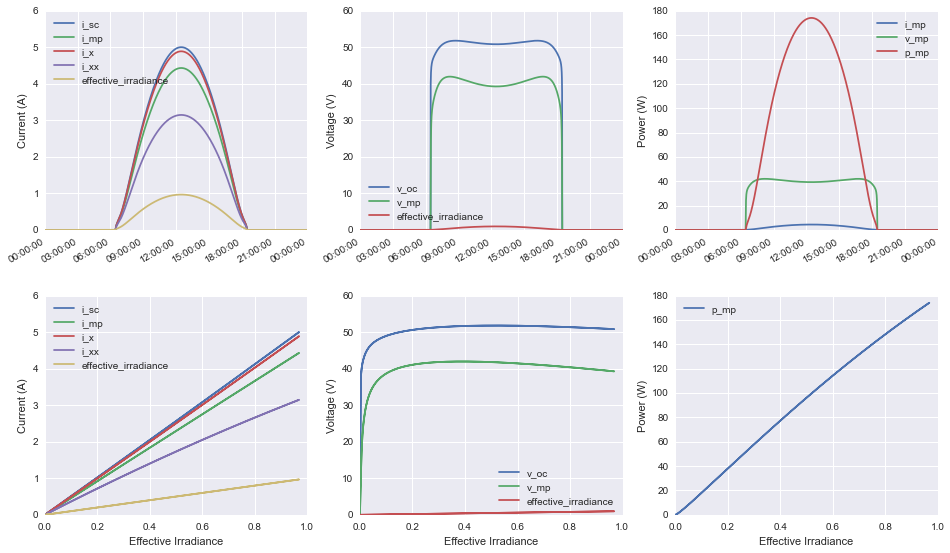

In [24]:
plot_sapm(sapm_1);

For comparison, here's the SAPM for a sunny, windy, cold version of the same day.

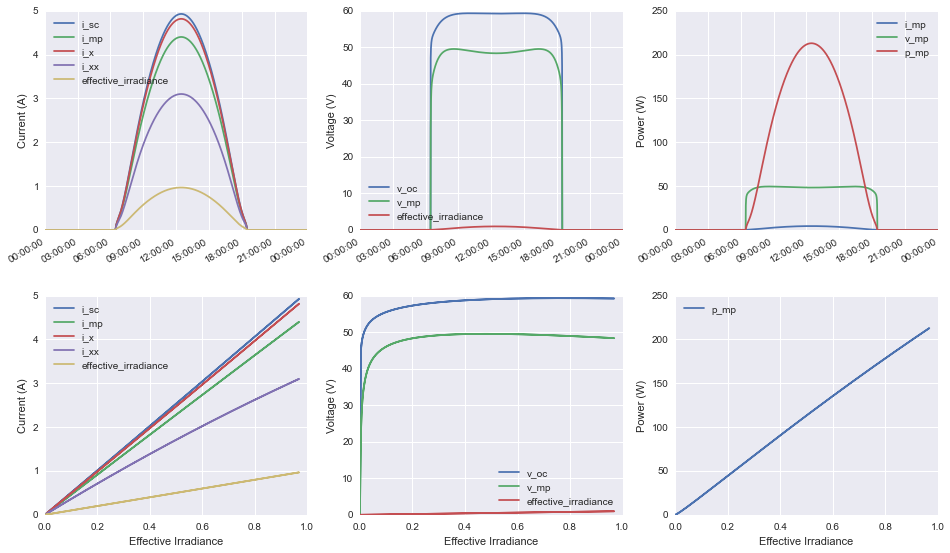

In [25]:
temps = pvsystem.sapm_celltemp(irrad_data['ghi'], 10, 5)

sapm_2 = pvsystem.sapm(sandia_module, irrad_data['dni']*np.cos(np.radians(aoi)),
                     irrad_data['dhi'], temps['temp_cell'], am, aoi)

plot_sapm(sapm_2)

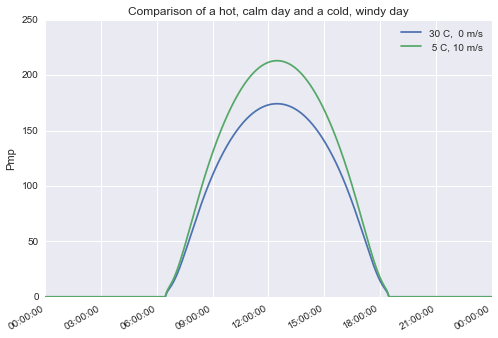

In [26]:
sapm_1['p_mp'].plot(label='30 C,  0 m/s');
sapm_2['p_mp'].plot(label=' 5 C, 10 m/s');
plt.legend();
plt.ylabel('Pmp');
plt.title('Comparison of a hot, calm day and a cold, windy day');

#### SAPM IV curves

In [27]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [28]:
def sapm_to_ivframe(sapm_row):
    pnt = sapm_row.T.ix[:,0]

    ivframe = {'Isc': (pnt['i_sc'], 0),
              'Pmp': (pnt['i_mp'], pnt['v_mp']),
              'Ix': (pnt['i_x'], 0.5*pnt['v_oc']),
              'Ixx': (pnt['i_xx'], 0.5*(pnt['v_oc']+pnt['v_mp'])),
              'Voc': (0, pnt['v_oc'])}
    ivframe = pd.DataFrame(ivframe, index=['current', 'voltage']).T
    ivframe = ivframe.sort('voltage')
    
    return ivframe

def ivframe_to_ivcurve(ivframe, points=100):
    ivfit_coefs = np.polyfit(ivframe['voltage'], ivframe['current'], 30)
    fit_voltages = np.linspace(0, ivframe.ix['Voc', 'voltage'], points)
    fit_currents = np.polyval(ivfit_coefs, fit_voltages)
    
    return fit_voltages, fit_currents

In [29]:
sapm_to_ivframe(sapm_1['2014-04-01 10:00:00'])

,current,voltage
Isc,3.943111,0.000000
Ix,3.850701,25.734151
Pmp,3.508231,40.603933
Ixx,2.559264,46.036117
Voc,0.000000,51.468302


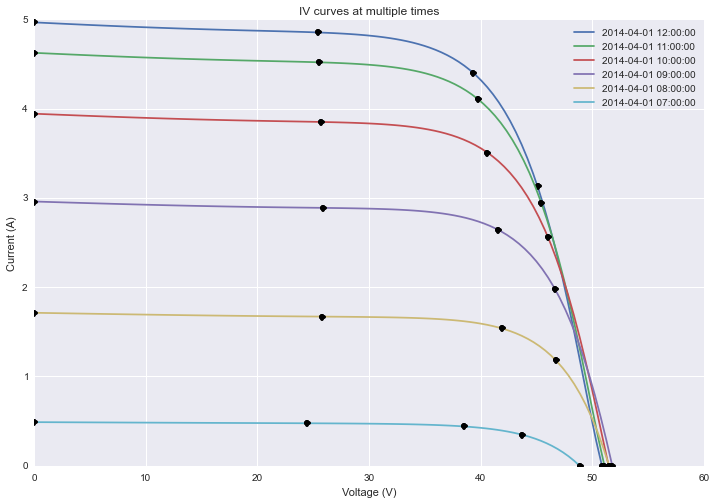

In [30]:
times = ['2014-04-01 07:00:00', '2014-04-01 08:00:00', '2014-04-01 09:00:00', 
         '2014-04-01 10:00:00', '2014-04-01 11:00:00', '2014-04-01 12:00:00']
times.reverse()

fig, ax = plt.subplots(1, 1, figsize=(12,8));

for time in times:
    ivframe = sapm_to_ivframe(sapm_1[time])

    fit_voltages, fit_currents = ivframe_to_ivcurve(ivframe)

    ax.plot(fit_voltages, fit_currents, label=time);
    ax.plot(ivframe['voltage'], ivframe['current'], 'ko');
    
ax.set_xlabel('Voltage (V)');
ax.set_ylabel('Current (A)');
ax.set_ylim(0, None);
ax.set_title('IV curves at multiple times');
ax.legend();

### desoto

The same data run through the desoto model.

In [31]:
photocurrent, saturation_current, resistance_series, resistance_shunt, nNsVth = (
    pvsystem.calcparams_desoto(irrad_data.ghi,
                                 temp_cell=temps['temp_cell'],
                                 alpha_isc=cecmodule['Alpha_sc'],
                                 module_parameters=cecmodule,
                                 EgRef=1.121,
                                 dEgdT=-0.0002677) )

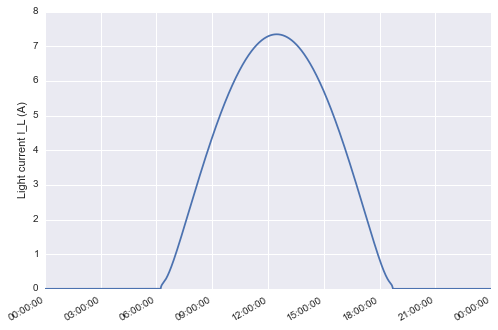

In [32]:
photocurrent.plot();
plt.ylabel('Light current I_L (A)');

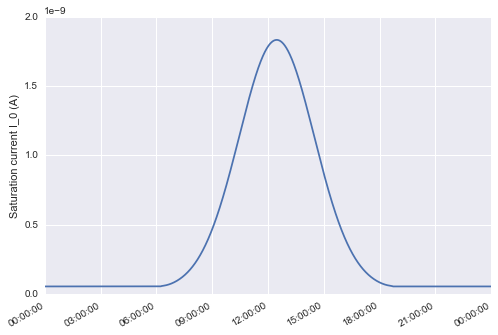

In [33]:
saturation_current.plot();
plt.ylabel('Saturation current I_0 (A)');

In [34]:
resistance_series

0.094

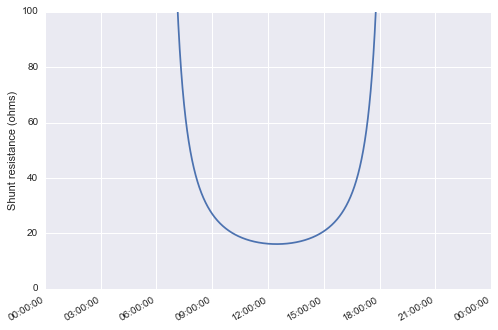

In [35]:
resistance_shunt.plot();
plt.ylabel('Shunt resistance (ohms)');
plt.ylim(0,100);

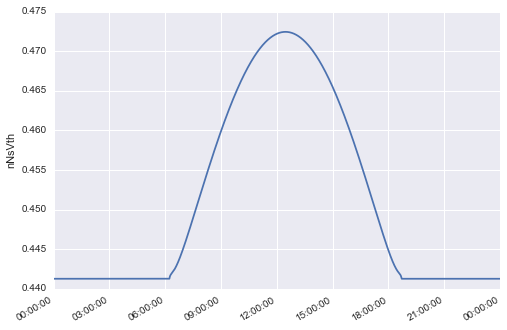

In [36]:
nNsVth.plot();
plt.ylabel('nNsVth');

### Single diode model

In [37]:
# pvsystem = reload(pvsystem)

In [38]:
single_diode_out = pvsystem.singlediode(cecmodule, photocurrent, saturation_current,
                                        resistance_series, resistance_shunt, nNsVth)
single_diode_out

,i_mp,i_sc,i_x,i_xx,p_mp,v_mp,v_oc
2014-04-01 00:00:00-07:00,NaN,NaN,NaN,NaN,NaN,0.022756,0.019739
2014-04-01 00:00:30-07:00,NaN,NaN,NaN,NaN,NaN,0.022756,0.019739
2014-04-01 00:01:00-07:00,NaN,NaN,NaN,NaN,NaN,0.022756,0.019739
2014-04-01 00:01:30-07:00,NaN,NaN,NaN,NaN,NaN,0.022756,0.019739
2014-04-01 00:02:00-07:00,NaN,NaN,NaN,NaN,NaN,0.022756,0.019739
2014-04-01 00:02:30-07:00,NaN,NaN,NaN,NaN,NaN,0.022756,0.019739
2014-04-01 00:03:00-07:00,NaN,NaN,NaN,NaN,NaN,0.022756,0.019739
2014-04-01 00:03:30-07:00,NaN,NaN,NaN,NaN,NaN,0.022756,0.019739
2014-04-01 00:04:00-07:00,NaN,NaN,NaN,NaN,NaN,0.022756,0.019739
2014-04-01 00:04:30-07:00,NaN,NaN,NaN,NaN,NaN,0.022756,0.019739


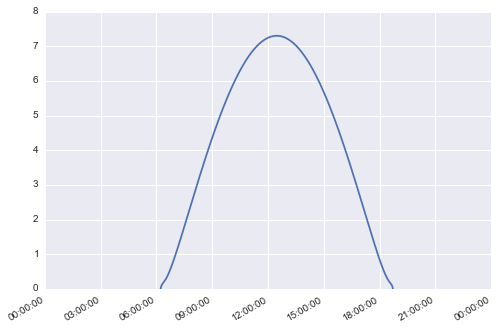

In [39]:
single_diode_out['i_sc'].plot();

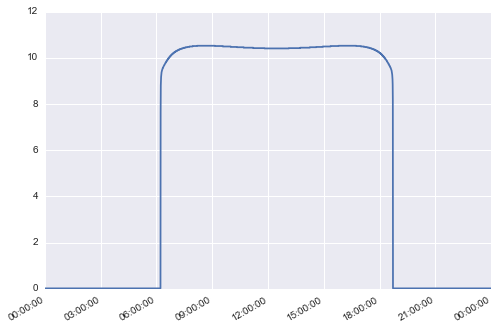

In [40]:
single_diode_out['v_oc'].plot();

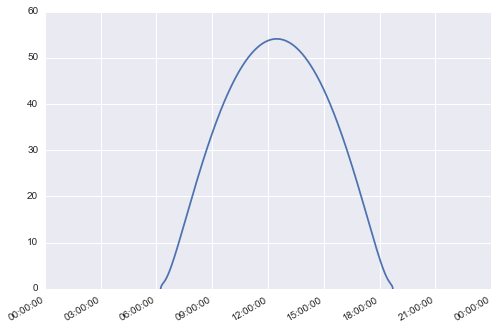

In [41]:
single_diode_out['p_mp'].plot();

## Python and [module versions, and dates](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [42]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, pandas, pvlib

Software versions
Python 2.7.8 32bit [MSC v.1500 32 bit (Intel)]
IPython 3.2.0
OS Windows 7 6.1.7601 SP1
numpy 1.9.2
scipy 0.15.1
matplotlib 1.4.3
pandas 0.16.2
pvlib 0.2.1dev
Sun Jul 12 14:30:49 2015 South Africa Standard Time